In [1]:
import re
import pandas as pd
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import tensorflow as tf

from flask import Flask, render_template, request

# Import Word dict

In [2]:
import json
with open(r'dataset/word2idx.json', "r") as f:
    word2idx = json.load(f)

In [3]:
max_word_length = 500
max_seq_length = 512

# Import embedding model

In [4]:
textCNN_model = load_model(r'model_save/model.h5')

layer_output = textCNN_model.get_layer('concatenate').output
intermediate_model = tf.keras.models.Model(inputs=textCNN_model.input,outputs=layer_output)

# Import JD

In [5]:
data = pd.read_csv(r'dataset/JD_dataset.csv',usecols = ['Query','Description'])
data.sample(10)

,Query,Description
14216,Business Analyst,<p>We are currently seeking a Businesss Analys...
54354,Mobile Tool Sales / Franchise Distributor,<strong></strong>\r<p>Do you enjoy outside sal...
34079,Java Developer,vtrIT is looking for three Java Developers to ...
27836,Mobile Tool Sales / Franchise Distributor,<strong></strong>\r<p>Do you enjoy outside sal...
20617,Cashier,<strong>When is a job more than just a job? </...
65204,Administrative Assistant,<strong>Classification: </strong> Secretary/A...
62138,Senior Accountant,<strong>Classification: </strong> Accountant ...
39105,Business Analyst,<B>Job Classification: </B> Contract \r\n\r\nO...
48986,Benefits Consultant,"<hr>\r<p align=""center""><strong>Account Repres..."
60264,Staff Accountant,<strong>Classification: </strong> Accountant ...


# JD Cleaning

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def clean_text(text):
    text = text.replace(r'\\n', ' ').replace(r'\\r', ' ').replace(r'\r', ' ').replace(r'\n', ' ')
    text = cleanr.sub(' ', text)
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 

    text = ' '.join(word for word in text.split()) # remove stopwors from text
    return text

def string_process(l):
    return l.split()[:max_word_length]

data['Description'] = data['Description'].apply(clean_text)
data['word_list'] = data['Description'].apply( string_process )
data.sample(10)

,Query,Description,word_list
61757,Sales / Customer Service – Part or Full time –...,want to get started with a rapidly growing and...,"[want, to, get, started, with, a, rapidly, gro..."
54953,Retail Sales Associate,our retail sales associates are in the best po...,"[our, retail, sales, associates, are, in, the,..."
30179,Financial Analyst,kelly financial resources is currently seeking...,"[kelly, financial, resources, is, currently, s..."
58372,Business Analyst,st vincent medical group navion healthcare sol...,"[st, vincent, medical, group, navion, healthca..."
17305,Account Executive,wtlvtv the #1 sales team in jacksonville flori...,"[wtlvtv, the, #1, sales, team, in, jacksonvill..."
37779,Mobile Tool Sales / Franchise Distributor,do you enjoy outside sales interacting with pe...,"[do, you, enjoy, outside, sales, interacting, ..."
571,Retail Wireless Sales Consultant,gowireless looking for a rewarding sales oppor...,"[gowireless, looking, for, a, rewarding, sales..."
18662,Project Manager,project manager supplylogic combines the benef...,"[project, manager, supplylogic, combines, the,..."
24300,Sales Representative,direct sales representative fcc environmental ...,"[direct, sales, representative, fcc, environme..."
53923,Administrative Assistant,administrative assistant must be professional ...,"[administrative, assistant, must, be, professi..."


In [7]:
def PreProcessInputData( text ):
    word_labels = []

    for sequence in text:
        len_text = len(sequence)

        ###########################################
        temp_word_labels = []
        for w in sequence:
            temp_word_labels.append( word2idx.get( str(w).lower(),1 ) )

        ###########################################
        temp_word_labels = temp_word_labels + [0] * ( max_seq_length - len_text )
        word_labels.append( temp_word_labels )

    return word_labels

# JD to vector matrix

In [8]:
def get_argmax( l ):
    return np.argmax(l)

In [9]:
XX = np.array( PreProcessInputData( data['word_list'] ) )
intermediate_prediction = intermediate_model.predict( XX )


YY = pd.get_dummies(data['Query']).values
data['category'] = list( YY )
data['category'] = data['category'].apply( get_argmax )


JD_Vector_List = []
for i in range(0,len(intermediate_prediction)):
    JD_Vector_List.append( intermediate_prediction[i][0][0] )

In [10]:
temp_DF = data[['Query','category']].drop_duplicates()

category_dict = {}
for ind, row in temp_DF.iterrows():
    category_dict[ row['category'] ] = row['Query']

category_dict

{2: 'Administrative Assistant',
 25: 'Sales Representative',
 7: 'Customer Service Representative',
 12: 'Java Developer',
 9: 'Financial Analyst',
 17: 'Project Manager',
 8: 'Executive Assistant',
 13: 'Maintenance Technician',
 16: 'Physical Therapist',
 29: 'Store Manager',
 28: 'Staff Accountant',
 10: 'Inside Sales Representative',
 0: 'Account Executive',
 18: 'Receptionist',
 27: 'Senior Accountant',
 4: 'Business Analyst',
 19: 'Restaurant Manager',
 1: 'Account Representative',
 20: 'Retail Sales Associate',
 26: 'Sales Representative / Account Manager /  Customer Service',
 21: 'Retail Wireless Sales Consultant',
 24: 'Sales Management Trainee',
 11: 'Jani-King Franchise Business Opportunity',
 15: 'Own Your Own Franchise!',
 5: 'Cashier',
 23: 'Sales / Franchise',
 6: 'Customer Service - Sales Representative - Part Time Work',
 14: 'Mobile Tool Sales / Franchise Distributor',
 3: 'Benefits Consultant',
 22: 'Sales / Customer Service – Part or Full time – Summer Work'}

In [11]:
y_list = YY
c_list = [ np.argmax(y) for y in y_list ]

In [ ]:
YY = pd.get_dummies(data['Query']).values
data['category'] = list( YY )
data['category'] = data['category'].apply( get_argmax )

    
temp_DF = data[['Query','category']].drop_duplicates()

category_dict = {}
for ind, row in temp_DF.iterrows():
    category_dict[ row['category'] ] = row['Query']
    
y_list = YY
c_list = [ np.argmax(y) for y in y_list ]

In [ ]:
from openTSNE import TSNE

X_tsne = TSNE().fit( np.array(JD_Vector_List) )

# PLot JD matrix

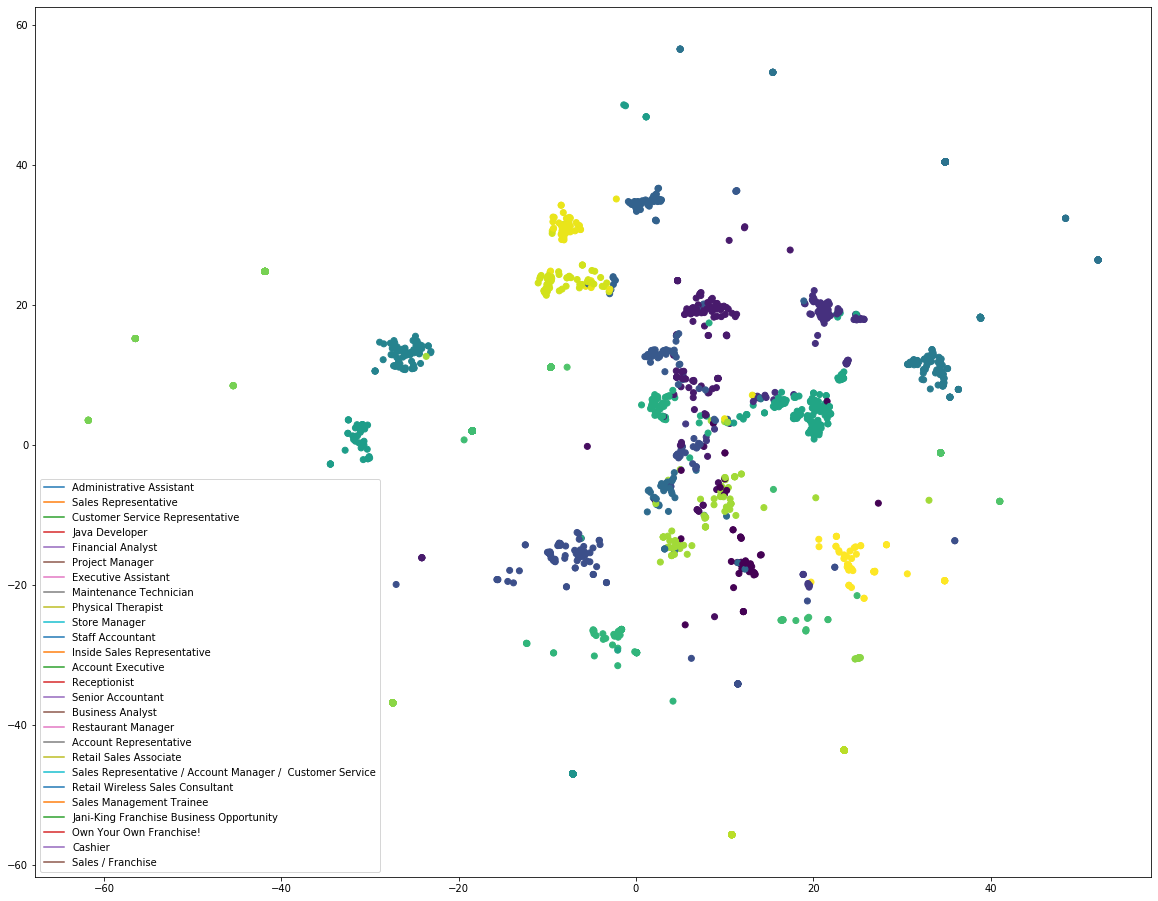

In [14]:
from openTSNE import TSNE

embedding = TSNE().fit( np.array(JD_Vector_List) )

import matplotlib.pyplot as plt

X_tsne = embedding

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)

label_list = []
for index in range(0,3000):

    if c_list[index] not in label_list:
        ax.plot( X_tsne[index][0], X_tsne[index][1],label = category_dict[c_list[index]]  )
        label_list.append( c_list[index] )
        
plt.scatter( X_tsne[:3000, 0], X_tsne[:3000, 1], c=c_list[:3000] )
plt.legend()
plt.savefig('foo1.png')
plt.show()

In [14]:
# 用 FAISS 对向量矩阵做索引

In [15]:
import numpy as np
import faiss                   # make faiss available

# 构造数据
import time
d = 500                           # dimension
nb = len(JD_Vector_List)                      # database size

np.random.seed(1234)             # make reproducible
xb = np.array( JD_Vector_List ).astype('float32')

In [17]:
# %time index = faiss.IndexFlatL2(d)   # build the index
faiss_index = faiss.IndexFlatL2(d)   # build the index

print(faiss_index.is_trained)
faiss_index.add(xb)                  # add vectors to the index
print(faiss_index.ntotal)

True
72292


# Start Flask

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:3335/ (Press CTRL+C to quit)


get_simmilar
business analyst singapore graduated with a degree in economics from the university of queensland i have experience working in an office environment and team setting from my time in national service and during internships i am a diligent and a fast learner and i place utmost importance in ensuring quality and professionalism in my workwork experiencebusiness analystmaybank singaporejune 2018 to presentuat coordinator to liaise between users and it to rectify defects and report progress of testing to project director extraction and reporting of uat progression and results from hp alm end to end testing for payment and settlement related projects capturing and extracting relevant data and compilation of test scripts liaise with it to ensure all backend screens as400 correctly shows transactions from user testsinterncimb bank singapore commercial banking compliance and operational riskjanuary 2017 to february 2017 administrative paperwork checking and organising of audit docu

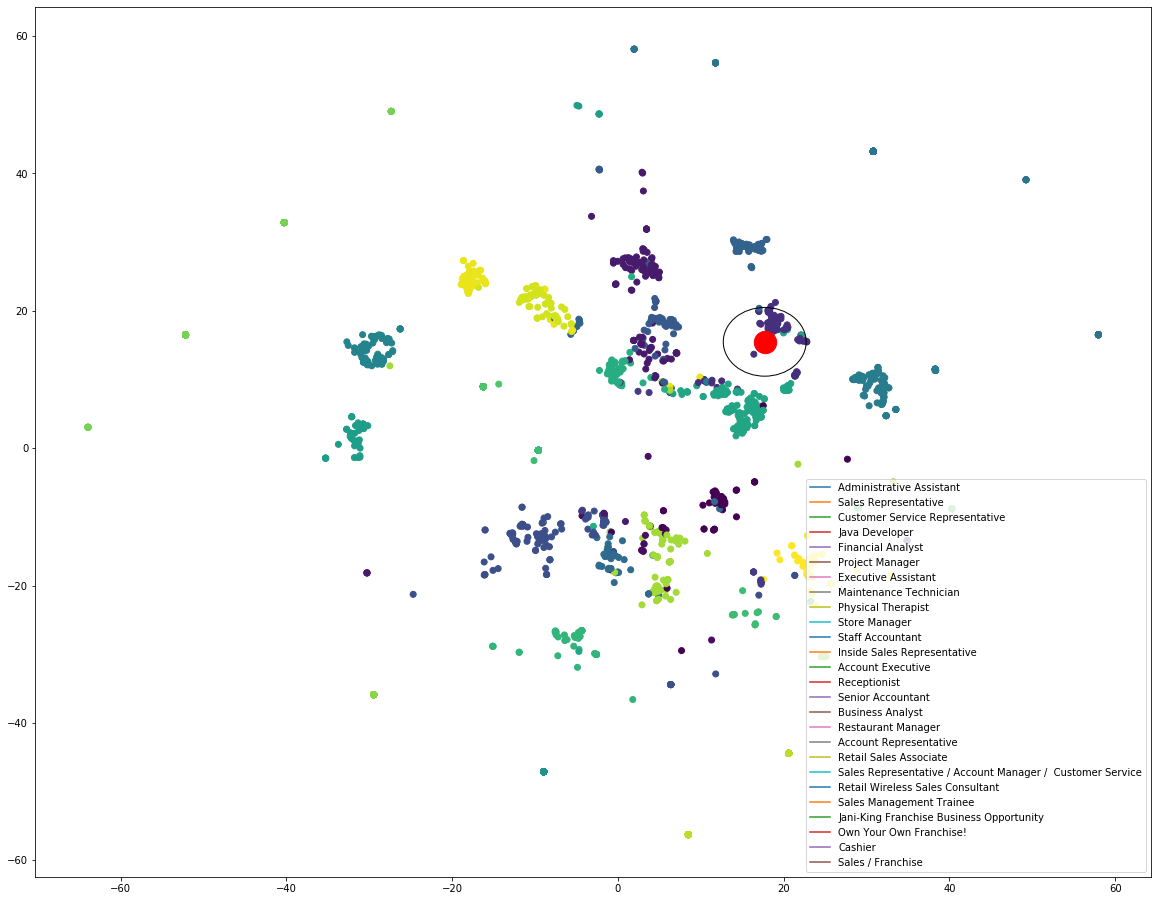

127.0.0.1 - - [27/Sep/2020 20:58:27] "POST /get_simmilar/ HTTP/1.1" 200 -


------------------------------------------------------------------------------------------------------------------------
Business Analyst 17.143680852660893 14.878040905237988
mission karat karat ha reengineered technical hiring ensure great talent get noticed great company augment engineering organization conducting firstrounds technical interview behalf use data analytics platform make hiring decision intelligent predictive service save material engineering time drive highly responsive consistent experience candidate karat continuously invests cutting edge interview methodology aim reducing bias letting candidate demonstrate true ability operate strategic partner engineering leader world s leading technology company including jet mulesoft pinterest indeed roblox intuit tenx minted many gold standard technical interviewing wellfunded company scaling quickly meet growing list client s need come join u ll work clean manipulate large volume data modeling analysis internal external stakeh

In [ ]:
app = Flask(__name__)

@app.route('/get_simmilar/', methods=['POST'])
# 返回最接近的向量
def get_simmilar():
    print( 'get_simmilar' )
    
    number = 5
    my_clean_text = clean_text( eval(request.get_data())['CV'] )
    print( my_clean_text )
    
    D, I = faiss_index.search( intermediate_model.predict( np.array( PreProcessInputData( [  my_clean_text.split()[:max_word_length] ] ) ) )[0][0] , number)
    
    
#     test_embedding = trans.transform( np.array( PreProcessInputData( [  my_clean_text.split()[:max_word_length] ] ) ) )
#     plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, cmap='Spectral')
#     plt.title('Embedding of the test set by UMAP', fontsize=24);
    # 返回最接近的职位描述
    
    p_x = 0
    p_y = 0
    

    for ind in I[0]:
        p_x += X_tsne[ind,0]
        p_y += X_tsne[ind,1]

    
    p_x = p_x/ number
    p_y = p_y/ number

    
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(111)

    label_list = []
    for index in range(0,3000):
        if c_list[index] not in label_list:
            ax.plot( X_tsne[index][0], X_tsne[index][1],label = category_dict[c_list[index]]  )
            label_list.append( c_list[index] )

    plt.scatter( X_tsne[:3000, 0], X_tsne[:3000, 1], c=c_list[:3000] )
    plt.legend()
    plt.scatter( p_x, p_y, s= 500, c = 'RED', marker = 'o')
    
#     plt.contour( p_x, p_y, 100, [9])
#     plt.Circle((p_x, p_y), r, color='y', fill=False)

    circle = plt.Circle((p_x, p_y), 5, color='BLACK', fill=False)
    plt.gcf().gca().add_artist(circle)

    plt.savefig('save.png')
    plt.show()
    
    response = {}
    for ind in I[0]:
        print('-'*120)
        print( data['Query'].iloc[ind] , X_tsne[ind,0] , X_tsne[ind,1])
        print( data['Description'].iloc[ind] )
        
        response[str(ind)] = data['Description'].iloc[ind]
    
    return str(response)

if __name__ == '__main__':
    app.run(host="0.0.0.0", port=3335)